### Imports

In [1]:
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import nltk as nltk
import pyarrow
import bz2
import json
import datetime
from iteration_utilities import deepflatten
import nltk as nltk
import scipy.stats as stats
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
pd.options.mode.chained_assignment = None
from textblob import TextBlob
from helpers import add_time, week, weekday_number, weekday, month, add_dict, to_dict, get_media, find_media
sns.set_theme(context='notebook', style='white')
plt.tight_layout()
import plotly.express as px

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Benjamin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<Figure size 432x288 with 0 Axes>

### Code for creating dataset

In [2]:
data_path = 'C:/Users/Benjamin/Desktop/Quotebank/'
files = ['quotes-2015.json.bz2','quotes-2016.json.bz2','quotes-2017.json.bz2',
                  'quotes-2018.json.bz2','quotes-2019.json.bz2','quotes-2020.json.bz2']

In [19]:
#defining sentiment analyzer
sent_analyzer = SentimentIntensityAnalyzer()

# Defining relevant media outlets
media_outlets = ['nytimes', 'wsj', 'womansday', 'nbcnews', 'foxnews', 'aarp', 'usmagazine', 'espn', 'usatoday', 
'newstoday', 'sportingnews', 'theguardian', 'people', 'tmz', 'mtv', 'cnn', 'msn', 'reuters', 'timesrepublican', 
'nationalgeographic', 'latimes', 'washingtonpost', 'startribune', 'chicagotribune', 'usnews', 'theathletic', 
'si', 'rollingstone', 'vanityfair', 'intouchweekly', 'starmagazine', 'bbc', 'independent', 'thesun', 'thetimes',
'express', 'dailymail', 'mirror', 'economist', ]

# Iterating through all the cleaned data sets in chunks and saving compound, polarity and subjectivity score, and media outlet
for x in range(len(files)): 
  print('Working on %d. dataset'%(x+1))
  df_reader = pd.read_json(data_path + files[x], lines=True, compression='bz2', chunksize=50000)
  a=0
  for chunk in df_reader:
    #Adding date, month, and weekday to the df
    chunk = add_time(chunk)
    
    #Calculating compound score with NLTK Vader
    chunk['compound'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

    #Computing polarity and subjectivity score with Text Blob
    chunk['polarity'] = chunk['quotation'].apply(lambda x: TextBlob(x).sentiment[0])
    chunk['subjectivity'] = chunk['quotation'].apply(lambda x: TextBlob(x).sentiment[1])

    #Adding the media outlet to the data frame if the media outlet is included in media_outlets
    chunk = get_media(chunk, media_outlets)
    
    # Only keeping relevant columns
    chunk = chunk[['date_short','compound','polarity','subjectivity','media_outlet','weekday', 'Month']]

    # Writing the chunk to a csv file
    chunk.to_csv(path_or_buf='C:/Users/Benjamin/Desktop/Quotebank/fil%d.csv.bz2'%x, compression='bz2', mode = 'a')

Working on 1. dataset
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loaded
loade

In [56]:
# Reading all quote files into one large dataframe
files = ['C:/Users/Benjamin/Desktop/Quotebank/fil%d.csv.bz2'%i for i in range(6)]
#df = pd.read_csv('C:/Users/Benjamin/Desktop/Quotebank/fil5.csv.bz2')
df = pd.concat(map(pd.read_csv, [files[0], files[1],files[2], files[3], files[4], files[5]]))

C:\Users\Benjamin\anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.



In [57]:
# Converting relevant columns to numeric
df['compound'] = pd.to_numeric(df.compound, errors='coerce')
df['polarity'] = pd.to_numeric(df.polarity, errors='coerce')
df['subjectivity'] = pd.to_numeric(df.subjectivity, errors='coerce')

# Dropping excessive column
df = df.drop('Unnamed: 0', axis=1)

# Sorting column by date
df = df.sort_values(by=['date_short'])

In [59]:
# Dropping rows with Nan values except for nan values in media_outlet
d = df.dropna(subset=['date_short','compound', 'polarity', 'subjectivity','weekday','Month'])

In [62]:
df.tail()

,date_short,compound,polarity,subjectivity,media_outlet,weekday,Month
17100341,date_short,NaN,NaN,NaN,media_outlet,weekday,Month
17150342,date_short,NaN,NaN,NaN,media_outlet,weekday,Month
17200343,date_short,NaN,NaN,NaN,media_outlet,weekday,Month
16150322,date_short,NaN,NaN,NaN,media_outlet,weekday,Month
25100501,date_short,NaN,NaN,NaN,media_outlet,weekday,Month


In [63]:
d.tail()

,date_short,compound,polarity,subjectivity,media_outlet,weekday,Month
2549961,2020-04-17,0.7506,0.250000,0.35,NaN,Friday,April
5020444,2020-04-17,0.0000,0.000000,0.00,NaN,Friday,April
2902381,2020-04-17,-0.5191,0.179167,0.45,NaN,Friday,April
1597999,2020-04-17,-0.2023,-0.187500,0.50,NaN,Friday,April
3854446,2020-04-17,0.0258,0.000000,0.00,NaN,Friday,April


In [66]:
print("Number of rows dropped: %d"%(df.size - d.size))

Number of rows dropped: 16177


In [67]:
# Writing the dataframe into new files containing only relevant information
d.to_csv(path_or_buf='C:/Users/Benjamin/Desktop/Quotebank/complete.csv.bz2', compression='bz2', mode = 'a')

### Analysis

In [2]:
df = pd.read_csv('C:/Users/Benjamin/Desktop/Quotebank/complete.csv.bz2', compression='bz2', index_col=0)

C:\Users\Benjamin\anaconda3\envs\ada\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df.head()

,date_short,compound,polarity,subjectivity,media_outlet,weekday,Month
2761852,2015-01-01,0.4795,0.375,0.75,NaN,Thursday,January
2574019,2015-01-01,0.0000,0.000,0.00,si,Thursday,January
17438571,2015-01-01,0.1027,0.000,1.00,NaN,Thursday,January
15664687,2015-01-01,0.0000,0.000,0.00,NaN,Thursday,January
7604764,2015-01-01,0.0000,-0.100,0.10,NaN,Thursday,January


In [4]:
df.tail()

,date_short,compound,polarity,subjectivity,media_outlet,weekday,Month
2549961,2020-04-17,0.7506,0.250000,0.35,NaN,Friday,April
5020444,2020-04-17,0.0000,0.000000,0.00,NaN,Friday,April
2902381,2020-04-17,-0.5191,0.179167,0.45,NaN,Friday,April
1597999,2020-04-17,-0.2023,-0.187500,0.50,NaN,Friday,April
3854446,2020-04-17,0.0258,0.000000,0.00,NaN,Friday,April


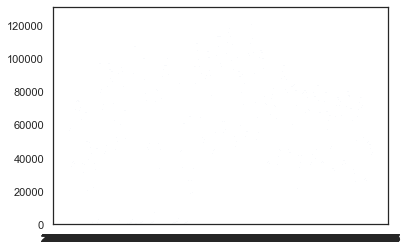

In [6]:
#extracting counts and bins for plotting
counts, bins, patches = plt.hist(df['date_short'], bins = 1934)

In [12]:
bins[1]

0.999482936918304

In [16]:
df_line = df.groupby('date_short').size()
df_line.head()

date_short
2015-01-01    27338
2015-01-02    36843
2015-01-03    26022
2015-01-04    27906
2015-01-05    48162
dtype: int64

In [18]:
fig = px.line(df_line)
fig.write_html('images/line_dig.html')

In [20]:
df_agg = df.groupby('date_short').mean()['compound']

In [21]:
fig = px.line(df_agg)
fig.write_html('images/line_comp.html')

In [36]:
df = df.sample(500000)

In [37]:
df_pol = df['polarity']
df_comp = df['compound']
df_sub = df['subjectivity']

In [ ]:
fig = px.bar(df, x='date_short', y='compound', histfunc='avg')
fig.write_html('image/comp_day'.html)

In [38]:
# showing distribution of sentiment scores
comp = px.histogram(df_comp, x='compound', title='Distribution of compound sentiment scores',nbins=20)
comp.write_html('images/comp_dist.html')
pol = px.histogram(df_pol, x='polarity', title='Distribution of polarity sentiment scores',nbins=20)
pol.write_html('images/pol_dist.html')
sub = px.histogram(df_sub, x='subjectivity', title='Distribution of subjectivity sentiment scores',nbins=20)
sub.write_html('images/sub_dist.html')

In [22]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig = px.box(df, x='weekday', y='compound', title='Distribution of compound score for weekdays',category_orders={'weekday':days})
fig.write_html('images/boxplot_day.html')

In [ ]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
fig2 = px.box(df, x='Month', y='compound', title='Distribution of compound score for months',category_orders={'Month':months})
fig2.write_html('images/boxplot_month.html')

In [ ]:
fig = px.histogram(df[df.weekday.isin(['Monday', 'Friday'])], x='compound', color='weekday', title='Compound sentiment score for Monday and Friday',nbins=20,histnorm='density')
fig.write_html('images/hist_monfri.html')


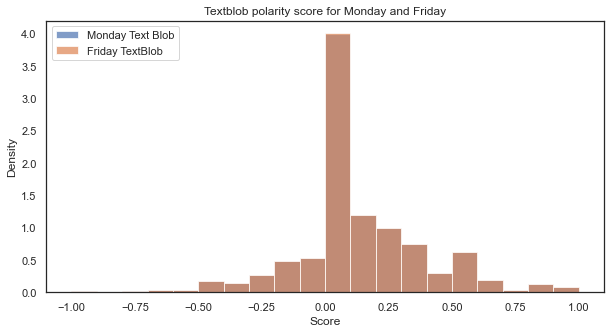

In [53]:
plt.figure(figsize=(10,5))
plt.hist(mon['polarity'], bins=20, alpha=0.7, density=True, label='Monday Text Blob')
plt.hist(fri['polarity'], bins=20, alpha=0.7, density=True, label='Friday TextBlob')
plt.title("Textblob polarity score for Monday and Friday")
plt.legend(loc='upper left')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

In [ ]:
fig = px.histogram(df[df.weekday.isin(['Monday', 'Friday'])], x='polarity', color='weekday', title='Polarity score for Monday and Friday',nbins=20,histnorm='density')
fig.write_html('images/hist_monfri_blob.html')

In [ ]:
t, p = stats.ttest_ind(mon['compound'], fri['compound'], equal_var=True)
print("Two sided paired t-test with null hypothesis: The mean mood on Mondays equals the mean mood on Fridays:")
print(f"t-value: {round(t,4)}, p-value: {round(p,4)}")

Two sided paired t-test with null hypothesis: The mean mood on Mondays equals the mean mood on Fridays:
t-value: 0.6206, p-value: 0.5349


In [ ]:
t, p = stats.ttest_ind(tue['compound'], sat['compound'], equal_var=True)
print("Two sided paired t-test with null hypothesis: The mean mood on Tuesdays equals the mean mood on Saturdays:")
print(f"t-value: {round(t,4)}, p-value: {round(p,4)}")

Two sided paired t-test with null hypothesis: The mean mood on Tuesdays equals the mean mood on Saturdays:
t-value: -50.8583, p-value: 0.0


In [ ]:
df_media = df.dropna()

MemoryError: Unable to allocate 815. MiB for an array with shape (3, 35594211) and data type float64

In [74]:
df_media['year'] = df_media['date_short'].apply(lambda x: int(x[0:4])-2014)
df_media.head()

,date_short,compound,polarity,subjectivity,media_outlet,weekday,Month,mon,tue,wed,thu,fri,sat,sun,year
2574019,2015-01-01,0.0000,0.000000,0.000000,si,Thursday,January,0,0,0,0,1,0,0,1
2574035,2015-01-01,0.0000,0.153333,0.566667,si,Thursday,January,0,0,0,0,1,0,0,1
9695253,2015-01-01,0.5859,-0.050000,0.262500,si,Thursday,January,0,0,0,0,1,0,0,1
5492291,2015-01-01,0.4404,0.000000,0.000000,express,Thursday,January,0,0,0,0,1,0,0,1
18042977,2015-01-01,0.5789,0.000000,0.000000,latimes,Thursday,January,0,0,0,0,1,0,0,1
